In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("avaitaion-data.csv")
df

,FlightNumber,DepartureDate,DepartureTime,ArrivalDate,ArrivalTime,Airline,DelayMinutes
0,AA1234,09/01/2023,08:30 AM,09/01/2023,10:45 AM,American Airlines,15.0
1,DL5678,09/01/2023,01:15 PM,09/01/2023,03:30 PM,Delta,5.0
2,UA9101,09/01/2023,05:00 PM,09/01/2023,07:15 PM,United Airlines,25.0
3,AA1234,09/01/2023,08:30 AM,09/01/2023,10:45 PM,American Airlines,30.0
4,DL5678,09/02/2023,02:00 PM,09/02/2023,04:10 PM,Delta,NaN
5,UA9101,09/02/2023,05:00 PM,09/02/2023,07:15 PM,United Airlines,20.0
6,AA1234,09/02/2023,08:30 PM,09/03/2023,10:45 AM,American Airlines,60.0
7,DL5678,09/03/2023,01:00 PM,09/03/2023,03:30 PM,Delta,10.0
8,UA9101,09/03/2023,03:00 PM,09/03/2023,05:20 PM,United Airlines,NaN
9,AA1234,09/03/2023,08:30 AM,09/03/2023,10:00 AM,American Airlines,15.0


In [4]:
# Step 1: Handle missing values by filling with the mean delay (for simplicity).
mean_delay = df["DelayMinutes"].mean()
df["DelayMinutes"].fillna(mean_delay, inplace=True)

# Step 2: Remove duplicate entries based on FlightNumber, DepartureDate, and DepartureTime.
df_cleaned = df.drop_duplicates(
    subset=["FlightNumber", "DepartureDate", "DepartureTime"], keep="first"
)

# Step 3: Convert dates to standard YYYY-MM-DD format and times to 24-hour format
df_cleaned["DepartureDate"] = pd.to_datetime(
    df_cleaned["DepartureDate"], format="%m/%d/%Y"
).dt.strftime("%Y-%m-%d")
df_cleaned["ArrivalDate"] = pd.to_datetime(
    df_cleaned["ArrivalDate"], format="%m/%d/%Y"
).dt.strftime("%Y-%m-%d")
df_cleaned["DepartureTime"] = pd.to_datetime(
    df_cleaned["DepartureTime"], format="%I:%M %p"
).dt.strftime("%H:%M")
df_cleaned["ArrivalTime"] = pd.to_datetime(
    df_cleaned["ArrivalTime"], format="%I:%M %p"
).dt.strftime("%H:%M")

# Display the cleaned data
df_cleaned

,FlightNumber,DepartureDate,DepartureTime,ArrivalDate,ArrivalTime,Airline,DelayMinutes
0,AA1234,2023-09-01,08:30,2023-09-01,10:45,American Airlines,15.0
1,DL5678,2023-09-01,13:15,2023-09-01,15:30,Delta,5.0
2,UA9101,2023-09-01,17:00,2023-09-01,19:15,United Airlines,25.0
4,DL5678,2023-09-02,14:00,2023-09-02,16:10,Delta,25.0
5,UA9101,2023-09-02,17:00,2023-09-02,19:15,United Airlines,20.0
6,AA1234,2023-09-02,20:30,2023-09-03,10:45,American Airlines,60.0
7,DL5678,2023-09-03,13:00,2023-09-03,15:30,Delta,10.0
8,UA9101,2023-09-03,15:00,2023-09-03,17:20,United Airlines,25.0
9,AA1234,2023-09-03,08:30,2023-09-03,10:00,American Airlines,15.0
10,DL5678,2023-09-04,12:30,2023-09-04,14:40,Delta,25.0


In [5]:
import os
from sql_connection import *
from dotenv import load_dotenv

load_dotenv()

DB_USERNAME = os.getenv("DB_USERNAME")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_NAME = os.getenv("DB_NAME")
DB_PORT = os.getenv("DB_PORT")

# Create connection
connection = create_connection(DB_HOST, DB_USERNAME, DB_PASSWORD, DB_NAME, DB_PORT)

# Insert data into MySQL (df_cleaned is the cleaned dataset)
insert_data(connection, df_cleaned)

# Fetch data back from MySQL
df = fetch_data(connection)

# Display fetched data
print(df.head())

MySQL Database connection successful
Data inserted successfully
   ID FlightNumber DepartureDate   DepartureTime ArrivalDate     ArrivalTime  \
0   1       AA1234    2023-09-01 0 days 08:30:00  2023-09-01 0 days 10:45:00   
1   2       DL5678    2023-09-01 0 days 13:15:00  2023-09-01 0 days 15:30:00   
2   3       UA9101    2023-09-01 0 days 17:00:00  2023-09-01 0 days 19:15:00   
3   4       DL5678    2023-09-02 0 days 14:00:00  2023-09-02 0 days 16:10:00   
4   5       UA9101    2023-09-02 0 days 17:00:00  2023-09-02 0 days 19:15:00   

             Airline  DelayMinutes  
0  American Airlines          15.0  
1              Delta           5.0  
2    United Airlines          25.0  
3              Delta          25.0  
4    United Airlines          20.0  


In [6]:
# Step 4: Handle inconsistent times by ensuring ArrivalTime is later than DepartureTime.
# We will assume that any flight with an ArrivalTime earlier than DepartureTime occurs the next day.

# Convert DepartureTime and ArrivalTime into timedelta for easy comparison
df_cleaned["DepartureDateTime"] = pd.to_datetime(
    df_cleaned["DepartureDate"] + " " + df_cleaned["DepartureTime"]
)
df_cleaned["ArrivalDateTime"] = pd.to_datetime(
    df_cleaned["ArrivalDate"] + " " + df_cleaned["ArrivalTime"]
)

# Adjust ArrivalDateTime if it occurs before DepartureDateTime (assume the arrival is the next day)
df_cleaned.loc[
    df_cleaned["ArrivalDateTime"] < df_cleaned["DepartureDateTime"], "ArrivalDateTime"
] += pd.Timedelta(days=1)

# Step 5: Create FlightDuration column by calculating the difference between ArrivalDateTime and DepartureDateTime
df_cleaned["FlightDuration"] = (
    df_cleaned["ArrivalDateTime"] - df_cleaned["DepartureDateTime"]
)

# Display the updated dataset with FlightDuration
df_cleaned[
    [
        "FlightNumber",
        "DepartureDateTime",
        "ArrivalDateTime",
        "FlightDuration",
        "Airline",
        "DelayMinutes",
    ]
]

,FlightNumber,DepartureDateTime,ArrivalDateTime,FlightDuration,Airline,DelayMinutes
0,AA1234,2023-09-01 08:30:00,2023-09-01 10:45:00,0 days 02:15:00,American Airlines,15.0
1,DL5678,2023-09-01 13:15:00,2023-09-01 15:30:00,0 days 02:15:00,Delta,5.0
2,UA9101,2023-09-01 17:00:00,2023-09-01 19:15:00,0 days 02:15:00,United Airlines,25.0
4,DL5678,2023-09-02 14:00:00,2023-09-02 16:10:00,0 days 02:10:00,Delta,25.0
5,UA9101,2023-09-02 17:00:00,2023-09-02 19:15:00,0 days 02:15:00,United Airlines,20.0
6,AA1234,2023-09-02 20:30:00,2023-09-03 10:45:00,0 days 14:15:00,American Airlines,60.0
7,DL5678,2023-09-03 13:00:00,2023-09-03 15:30:00,0 days 02:30:00,Delta,10.0
8,UA9101,2023-09-03 15:00:00,2023-09-03 17:20:00,0 days 02:20:00,United Airlines,25.0
9,AA1234,2023-09-03 08:30:00,2023-09-03 10:00:00,0 days 01:30:00,American Airlines,15.0
10,DL5678,2023-09-04 12:30:00,2023-09-04 14:40:00,0 days 02:10:00,Delta,25.0


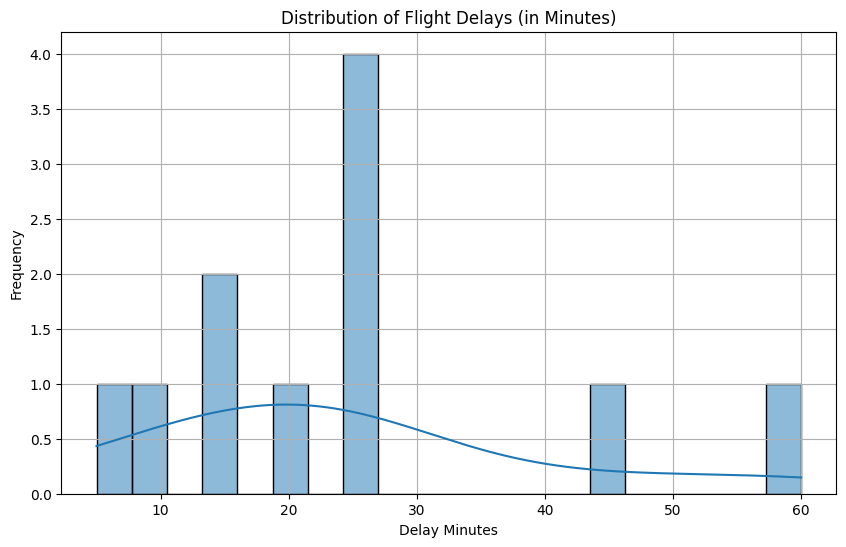

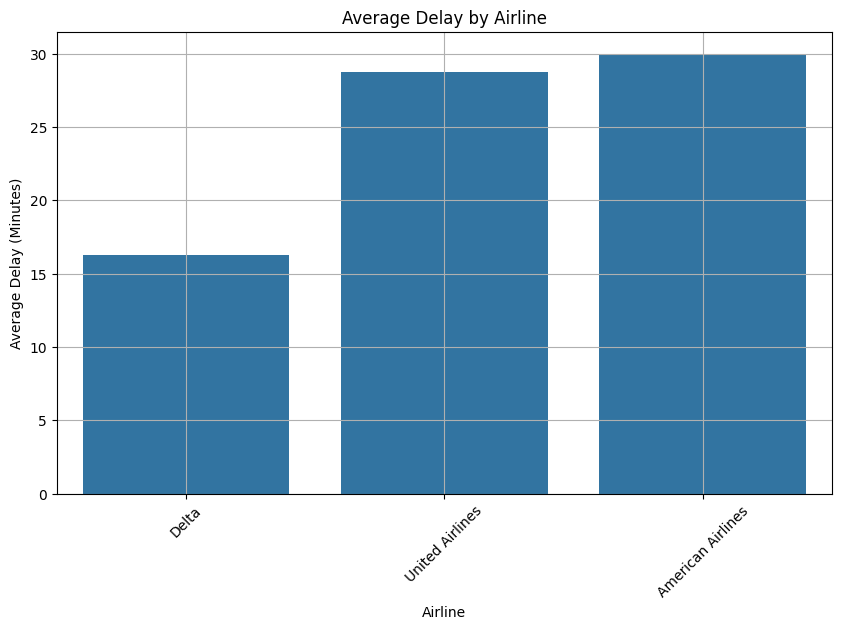

Airline
Delta                16.25
United Airlines      28.75
American Airlines    30.00
Name: DelayMinutes, dtype: float64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Analyze the distribution of delays
plt.figure(figsize=(10, 6))
sns.histplot(df_cleaned["DelayMinutes"], bins=20, kde=True)
plt.title("Distribution of Flight Delays (in Minutes)")
plt.xlabel("Delay Minutes")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Step 2: Calculate the average delay per airline
avg_delay_per_airline = (
    df_cleaned.groupby("Airline")["DelayMinutes"].mean().sort_values()
)

# Step 3: Visualize average delay by airline
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_delay_per_airline.index, y=avg_delay_per_airline.values)
plt.title("Average Delay by Airline")
plt.xlabel("Airline")
plt.ylabel("Average Delay (Minutes)")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

avg_delay_per_airline